# Self-Supervised Learning with Contrastive Loss on Blood Cell Images

In [1]:
%reload_ext autoreload
%autoreload 2
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import os

# 1. Data

In [2]:
class BloodDataset(Dataset):
    """
    Custom dataset for blood cell images (self-supervised learning)
    """
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = datasets.ImageFolder(root, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, _ = self.data[idx]  # Ignore the label
        return image

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor()
])

train_dataset = BloodDataset('data/images/TRAIN', transform=transform)
test_dataset = BloodDataset('data/images/TEST', transform=transform)
test_simple_dataset = BloodDataset('data/images/TEST_SIMPLE', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_simple_loader = DataLoader(test_simple_dataset, batch_size=32, shuffle=False)

In [4]:
def imshow(img, label=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if label:
        plt.title(label)
    plt.show()
def show_batch(batch):
    images = batch
    grid = torchvision.utils.make_grid(images)
    imshow(grid)

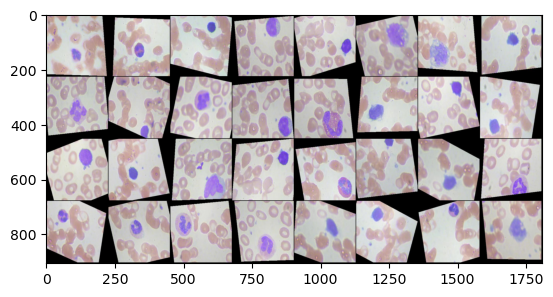

In [5]:
batch = next(iter(train_loader))
show_batch(batch)

# 2. Model

In [6]:
from model import BloodSimNet
from loss import ContrastiveLoss
from utils import data_augmentation

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: mps


In [8]:
model = BloodSimNet().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training

In [9]:
# Training loop
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader, total=len(train_loader), desc='Training')):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Data augmentation
        x1 = data_augmentation(batch).to(device)
        x2 = data_augmentation(batch).to(device)
        
        # Forward pass
        z1 = model(x1)
        z2 = model(x2)
        
        # Compute loss
        loss = criterion(z1, z2)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(train_loader)

In [10]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    loss = train(model, criterion, optimizer, train_loader, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')
    
    # Save the model
    if os.path.exists(f'models/{model}') is False:
        os.makedirs(f'models/{model}')
    torch.save(model.state_dict(), f'models/{model}/{model}-{epoch+1}.pth')

Training: 100%|██████████| 312/312 [04:14<00:00,  1.23it/s]


Epoch 1/5, Loss: 2.6283933829802733


Training: 100%|██████████| 312/312 [03:59<00:00,  1.30it/s]


Epoch 2/5, Loss: 2.506184391486339


Training: 100%|██████████| 312/312 [03:56<00:00,  1.32it/s]


Epoch 3/5, Loss: 2.481933471101981


Training: 100%|██████████| 312/312 [04:14<00:00,  1.23it/s]


Epoch 4/5, Loss: 2.469324130278367


Training: 100%|██████████| 312/312 [04:06<00:00,  1.27it/s]


Epoch 5/5, Loss: 2.460933103775367


# 4. Testing

In [11]:
from sklearn.manifold import TSNE

In [42]:
# Test the model
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(test_loader, total=len(test_loader), desc='Testing'):
        batch = batch.to(device)
        embeddings.append(model(batch).cpu().numpy())
        
embeddings = np.concatenate(embeddings)

Testing: 100%|██████████| 78/78 [00:08<00:00,  9.54it/s]


In [43]:
# Apply K-means clustering to the embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
pseudo_labels = kmeans.fit(embeddings)

In [44]:
# Visualize the embeddings using t-SNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(embeddings)

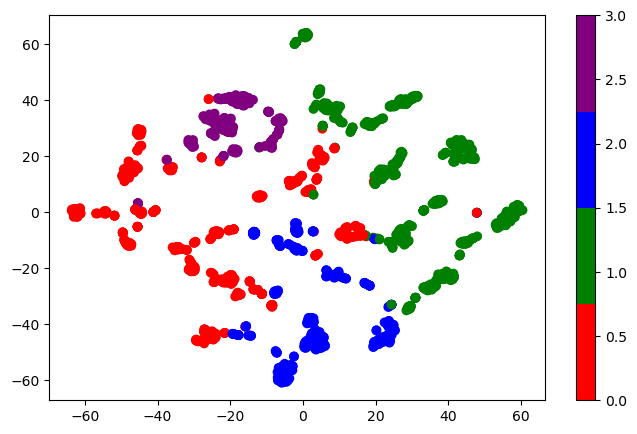

In [45]:
plt.figure(figsize=(8, 5))
colors = ['red', 'green', 'blue', 'purple']
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pseudo_labels.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()
plt.show()